<a href="https://colab.research.google.com/github/Ahmed-Fayed/AI-Codes/blob/main/Copy_of_Leukemia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Dependencies

In [1]:
!pip install Augmentor
!pip install mlxtend

# Connecting to Google Drive 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tqdm

import tensorflow as tf

from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.python.client.device_lib import list_local_devices
from tensorflow.keras.applications.vgg19 import VGG19
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
import Augmentor


# Print devices that google colab connected to it
print(list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3601605988216705433
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11232496615506237620
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


**as we can see google colab is connected with CPU and GPU, so now we can use GPU for faster processing**

# Coonecting to the dataset in google drive

In [4]:
# Connect to dataset in google drive
dataset_path = r'/content/drive/MyDrive/Leukemia Classification'

# Make sure we have read the dataset from google drive correctly,
# and now we have the two classes 'nornal' and 'blast'
folders=os.listdir(dataset_path)
folders

['blast', 'normal']

# Reading Dataset

In [5]:
# Lists that we will append the images and labels to it
scans=[]
labels=[]

# Walking through dataset classes
for folder in folders:
    images=os.listdir(os.path.join(dataset_path,folder))
#     print(images)
    
    # Walking through all images in each class
    for img in tqdm.tqdm(images):
        img_path=os.path.join(dataset_path,folder,img)
#         print(img_path)
        # Reading the image using opencv
        scan=cv2.imread(img_path)

        # Resize the image to desired height and width
        scan=cv2.resize(scan ,(257,257))

        # Converting the images from BGR (default order of channels in opencv) to RGB (Normal order of channels)
        scan=cv2.cvtColor(scan, cv2.COLOR_BGR2RGB)
        
        #add data to lists
        scans.append(scan)
        if folder== "blast":
            labels.append(1)
        else :
            labels.append(0)
            
        
    

100%|██████████| 1059/1059 [01:30<00:00, 11.70it/s]


**Explroing shape of iamges dataset and labels list**

In [6]:
scans=np.array(scans)
labels=np.array(labels)
scans.shape,labels.shape

((2108, 257, 257, 3), (2108,))

**Exploring Labels Counts**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


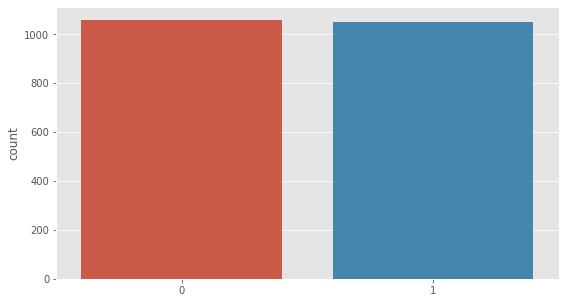

In [7]:
# plot the labels to see the balance of classes in the dataset
plt.style.use("ggplot")
plt.figure(figsize=(9, 5))
sns.countplot(labels)
plt.show()

# Explroing samples from dataset

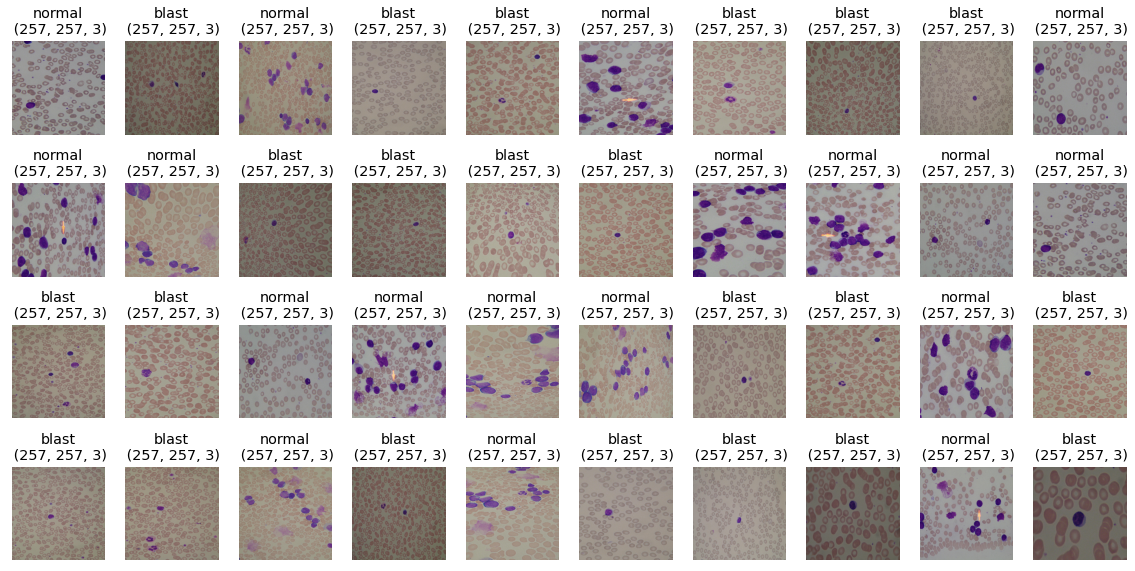

In [8]:
#function to show images
def image_show(data, labels , number_of_image ):
    #to generate a random numbers
    numbers=np.random.randint(0,len(data),number_of_image)
    plt.figure(figsize=(20,10))
    j = int(number_of_image/10)
    for _,i in enumerate(numbers):
        plt.subplot(j,10,_+1)
        plt.imshow(data[i])
        plt.title(folders[labels[i]]+"\n"+f" {data[i].shape}")
        #to remove the number that appear around image
        plt.xticks([]),plt.yticks([])
    plt.show()


# show sample of my dataset
image_show(scans, labels , 40 )

# split the dataset

In [9]:
# split dateset into training and testing
Xtrain,Xtest, Ytrain,Ytest =train_test_split(scans,labels,test_size=0.2,stratify=labels, random_state=42, shuffle=True)

# split training dataset into training and validation dataset
Xtrain,Xval, Ytrain,Yval =train_test_split(Xtrain,Ytrain,test_size=0.05,stratify=Ytrain, random_state=42, shuffle=True)

# Explroing shape of training, validation and testing dataset
print("#######################################################################\n\n")
print("Shape of Training data ", Xtrain.shape)
print("Shape of Training Labels ", Ytrain.shape)
print("-----------------------------------------------------------------------\n\n")
print("Shape of Validation data ", Xval.shape)
print("Shape of Validation Labels ", Yval.shape)
print("-----------------------------------------------------------------------\n\n")

print("Shape of Testing data ", Xtest.shape)
print("Shape of Testing Labels ", Ytest.shape)

print("#######################################################################\n\n")

#######################################################################


Shape of Training data  (1601, 257, 257, 3)
Shape of Training Labels  (1601,)
-----------------------------------------------------------------------


Shape of Validation data  (85, 257, 257, 3)
Shape of Validation Labels  (85,)
-----------------------------------------------------------------------


Shape of Testing data  (422, 257, 257, 3)
Shape of Testing Labels  (422,)
#######################################################################




### show Training data

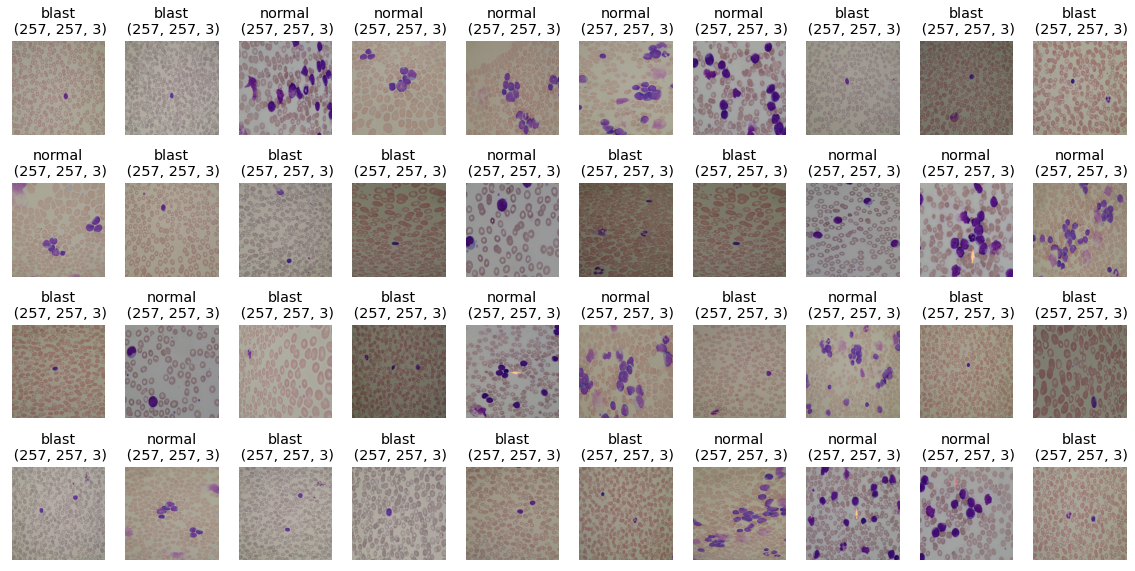

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


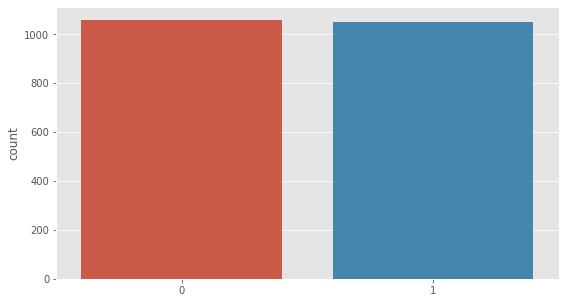

In [10]:
image_show(Xtrain, Ytrain , 40 )
plt.style.use("ggplot")
plt.figure(figsize=(9, 5))

# show balance of classes in training dataset
sns.countplot(labels)
plt.show()

# Build DenseNet169 Model

In [11]:
# Take instance from DenseNet169 to make transfere Learning
model = DenseNet169(include_top=False, weights='imagenet', input_shape=(257, 257, 3))

# Freezing the layers because we want our own layers only to train
for layer in model.layers:
    layer.trainable = False


# model.summary()

# Making our custom layers

inputs = model.layers[-1].output

x = Flatten()(inputs)
x = Dense(64, activation='relu')(x)


predictions_layer = Dense(1, activation='sigmoid')(x)

DenseNet169 = Model(inputs=model.input, outputs=predictions_layer)

# Show Architecture of the DenseNet169 Model
DenseNet169.summary()


51888128/51877672 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 257, 257, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 263, 263, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 129, 129, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [12]:
# Configure the model with the desired optimizer, loss function and metrics
DenseNet169.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ModelCheckpoint callback to track the performance of the model and save the best weights during training
# CSVLogger callback to record performance of the model during training in csv file
callbacks_list = [
    # EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='DenseNet169_best_weights.h5', monitor='val_loss', verbose=1, save_best_only=True),
    CSVLogger(filename='DenseNet169 training performance.csv')]



history_DenseNet169 = DenseNet169.fit(Xtrain,Ytrain,
                                    epochs=5,
                                    verbose=1,
                                    callbacks=callbacks_list,
                                    validation_data=(Xval,Yval))

DenseNet169.save('DenseNet169_Last_weights.h5')

Epoch 1/5
51/51 [==============================] - ETA: 0s - loss: 2.1099 - accuracy: 0.9482
Epoch 00001: val_loss improved from inf to 0.00000, saving model to DenseNet169_best_weights.h5
51/51 [==============================] - 33s 290ms/step - loss: 2.1099 - accuracy: 0.9482 - val_loss: 8.2720e-26 - val_accuracy: 1.0000
Epoch 2/5
50/51 [============================>.] - ETA: 0s - loss: 0.0936 - accuracy: 0.9962
Epoch 00002: val_loss did not improve from 0.00000
51/51 [==============================] - 8s 151ms/step - loss: 0.0935 - accuracy: 0.9963 - val_loss: 1.3340e-15 - val_accuracy: 1.0000
Epoch 3/5
50/51 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.9969
Epoch 00003: val_loss did not improve from 0.00000
51/51 [==============================] - 7s 146ms/step - loss: 0.0303 - accuracy: 0.9969 - val_loss: 0.1321 - val_accuracy: 0.9882
Epoch 4/5
50/51 [============================>.] - ETA: 0s - loss: 5.5911e-07 - accuracy: 1.0000
Epoch 00004: val_loss di

## Evaluate the model

- the Accuracy and Loss for DenseNet169 Model With 10 Epochs


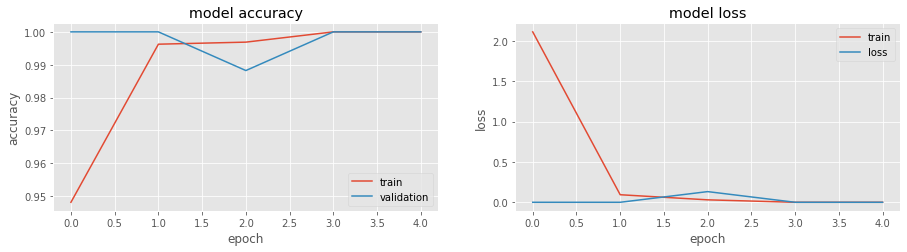

In [13]:
print("- the Accuracy and Loss for DenseNet169 Model With 10 Epochs")
plt.figure(figsize=(40,20))


# summarize history for accuracy 
plt.subplot(5,5,1)
plt.plot(history_DenseNet169.history['accuracy'])
plt.plot(history_DenseNet169.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='lower right')


# summarize history for loss
plt.subplot(5,5,2)
plt.plot(history_DenseNet169.history['loss'])
plt.plot(history_DenseNet169.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','loss'], loc='upper right')
plt.show()

### confusion matrix on Test data

In [14]:
DenseNet196_pred = DenseNet169.predict(Xtest)
DenseNet196_pred = DenseNet196_pred > 0.6

[[212   1]
 [  0 209]]



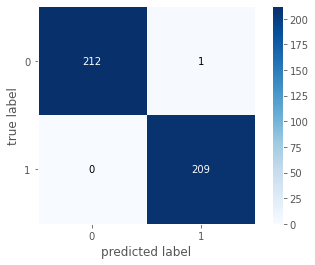


Classification Report for DenesNet 169 Model is : 
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       213
        True       1.00      1.00      1.00       209

    accuracy                           1.00       422
   macro avg       1.00      1.00      1.00       422
weighted avg       1.00      1.00      1.00       422



In [15]:
#confusion matrix   Model
from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import confusion_matrix
DenseNet196_cm=confusion_matrix(DenseNet196_pred, Ytest)
print(DenseNet196_cm)
print()
#Visualizing confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=DenseNet196_cm,
                                colorbar=True)
plt.show()

###############################################################################################################################

#Classification Report  for Model
from sklearn.metrics import classification_report
ClassificationReport = classification_report(DenseNet196_pred, Ytest)
print()
print('Classification Report for DenesNet 169 Model is : \n', ClassificationReport )

### Computing Sensitivity

**Sensitivity = True Positive / (True Positive + False Negative)**

DenseNet196_cm[1,1]: True Positive

DenseNet196_cm[1,0]: False Negative

In [16]:
DenseNet169_sensitivity = DenseNet196_cm[1,1] / (DenseNet196_cm[1,1] + DenseNet196_cm[1,0])
print('Sensitivity : ', DenseNet169_sensitivity)

Sensitivity :  1.0


###Computing Specificity

**Specificity = True Negative / (True Negative + False Positive)**

DenseNet196_cm[0,0]: True Negative

DenseNet196_cm[0,1]: False Positive

In [17]:
DenseNet169_specificity = DenseNet196_cm[0,0] / (DenseNet196_cm[0,0] + DenseNet196_cm[0,1])
print('Specificity : ', DenseNet169_specificity)

Specificity :  0.9953051643192489


In [18]:
def plot_roc(y_pred, model_name=''):
    n_classes = 2

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Ytest[:], y_pred[:])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    #Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Ytest.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.style.use('seaborn-whitegrid')
    sns.set(style="white", font_scale = 1.2)
    plt.figure(figsize=(12,12))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    colors = ['aqua', 'darkorange', 'cornflowerblue', "red", "green", "black"]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='{0} (area = {1:0.2f})'
                 ''.format(folders[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for each class using ' + model_name + ' Model')
    plt.legend(loc="lower right")
    
    plt.show()


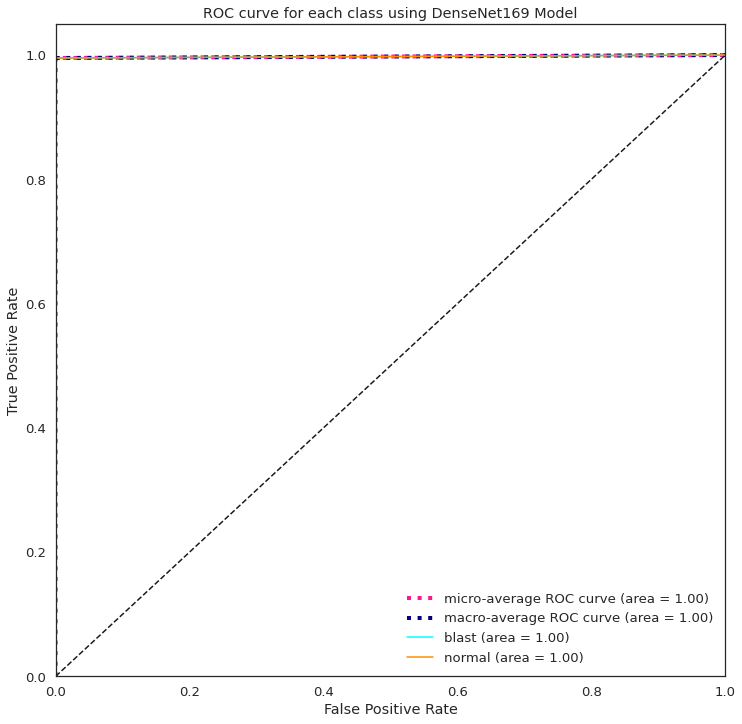

In [19]:
plot_roc(DenseNet196_pred, 'DenseNet169')

# Build VGG19

In [20]:
# Take instance from DenseNet169 to make transfere Learning
model = VGG19(include_top=False, weights='imagenet', input_shape=(257, 257, 3))

print("Vgg19 layers : ",len(model.layers) )

# Freezing the layers because we want our own layers only to train
for layer in model.layers:
    layer.trainable = False


# model.summary()

# Making our custom layers
inputs = model.layers[-1].output

x = Flatten()(inputs)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

predictions_layer = Dense(1, activation='sigmoid', kernel_regularizer='l2')(x)

VGG19 = Model(inputs=model.input, outputs=predictions_layer)

VGG19.summary()


80150528/80134624 [==============================] - 1s 0us/step
Vgg19 layers :  22
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 257, 257, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 257, 257, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 257, 257, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                         

In [21]:
# Configure the model with the desired optimizer, loss function and metrics
VGG19.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ModelCheckpoint callback to track the performance of the model and save the best weights during training
# CSVLogger callback to record performance of the model during training in csv file
callbacks_list = [
    # EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='VGG19_best_weights.h5', monitor='val_loss', verbose=1, save_best_only=True),
    CSVLogger(filename='VGG19 training performance.csv')]



history_VGG19 = VGG19.fit(Xtrain,Ytrain,
                                    epochs=10,
                                    verbose=1,
                                    callbacks=callbacks_list,
                                    validation_data=(Xval,Yval))

VGG19.save('VGG19_Last_weights.h5')


Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 1.5327 - accuracy: 0.8819
Epoch 00001: val_loss improved from inf to 0.01677, saving model to VGG19_best_weights.h5
51/51 [==============================] - 24s 313ms/step - loss: 1.5327 - accuracy: 0.8819 - val_loss: 0.0168 - val_accuracy: 1.0000
Epoch 2/10
50/51 [============================>.] - ETA: 0s - loss: 0.0810 - accuracy: 0.9856
Epoch 00002: val_loss did not improve from 0.01677
51/51 [==============================] - 10s 195ms/step - loss: 0.0810 - accuracy: 0.9856 - val_loss: 0.0285 - val_accuracy: 0.9882
Epoch 3/10
50/51 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9875
Epoch 00003: val_loss improved from 0.01677 to 0.01642, saving model to VGG19_best_weights.h5
51/51 [==============================] - 10s 202ms/step - loss: 0.0986 - accuracy: 0.9875 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 4/10
50/51 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 

- the Accuracy and Loss for VGG19 Model With 10 Epochs


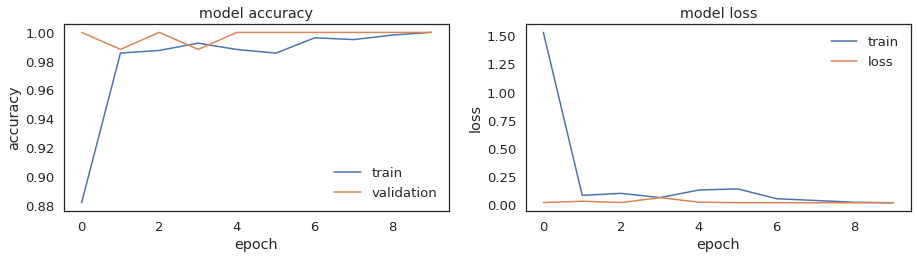

In [22]:
print("- the Accuracy and Loss for VGG19 Model With 10 Epochs")
plt.figure(figsize=(40,20))


# summarize history for accuracy 
plt.subplot(5,5,1)
plt.plot(history_VGG19.history['accuracy'])
plt.plot(history_VGG19.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='lower right')


# summarize history for loss
plt.subplot(5,5,2)
plt.plot(history_VGG19.history['loss'])
plt.plot(history_VGG19.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','loss'], loc='upper right')
plt.show()

### confusion matrix on Test data


In [23]:
VGG19_pred = VGG19.predict(Xtest)
VGG19_pred = VGG19_pred > 0.6

[[209   0]
 [  3 210]]



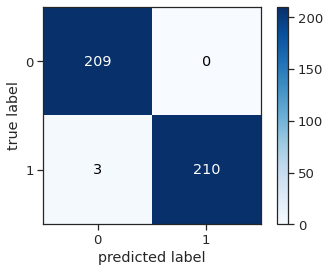


Classification Report for DenesNet 169 Model is : 
               precision    recall  f1-score   support

       False       0.99      1.00      0.99       209
        True       1.00      0.99      0.99       213

    accuracy                           0.99       422
   macro avg       0.99      0.99      0.99       422
weighted avg       0.99      0.99      0.99       422



In [24]:

#confusion matrix   Model
from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import confusion_matrix
vgg19_cm=confusion_matrix(VGG19_pred, Ytest)
print(vgg19_cm)
print()
#Visualizing confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=vgg19_cm,
                                colorbar=True)
plt.show()

###############################################################################################################################

#Classification Report  for Model
from sklearn.metrics import classification_report
ClassificationReport = classification_report(VGG19_pred, Ytest)
print()
print('Classification Report for DenesNet 169 Model is : \n', ClassificationReport )

### Computing Sensitivity

**Sensitivity = True Positive / (True Positive + False Negative)**

vgg19_cm[1,1]: True Positive

vgg19_cm[1,0]: False Negative

In [25]:
vgg19_sensitivity = vgg19_cm[1,1] / (vgg19_cm[1,1] + vgg19_cm[1,0])
print('vgg19 Sensitivity : ', vgg19_sensitivity)

vgg19 Sensitivity :  0.9859154929577465


### Computing Specificity

**Specificity = True Negative / (True Negative + False Positive)**

vgg19_cm[0,0]: True Positive

vgg19_cm[0,1]: False Negative

In [26]:
vgg19_specificity = vgg19_cm[0,0] / (vgg19_cm[0,0] + vgg19_cm[0,1])
print('vgg19 Specificity : ', vgg19_specificity)

vgg19 Specificity :  1.0


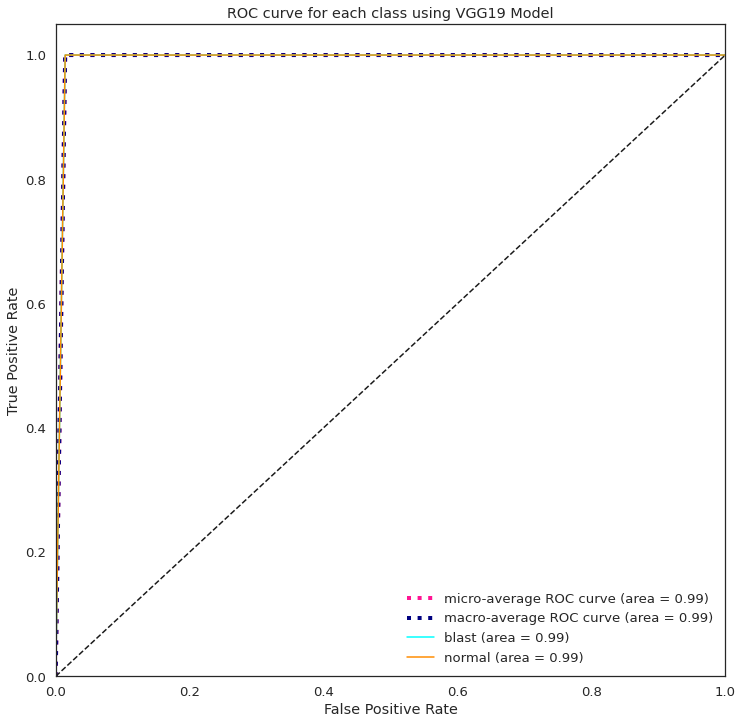

In [27]:
plot_roc(VGG19_pred, 'VGG19')